In [1]:
# importing the libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from itertools import chain
import seaborn as sns

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.image import resample_img
from nilearn.image import new_img_like, load_img, clean_img, crop_img
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from glob import glob

# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import h5py
from torchsummary import summary

from IPython import display
%matplotlib inline

In [2]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

class MyDataset(Dataset):
    def __init__(self, task_type, test_size=0.2, test=False, scaler='minmax',
                path='../../brainmask_reg/*.npy'):

        self.scaler = scaler

        RANDOM_STATE = 42
        np.random.seed(RANDOM_STATE)

        data_files = glob(path)
        data_files.sort()

        test_num = int(test_size * len(data_files))
        train_num = len(data_files) - test_num
        shuffled_index = np.random.permutation(len(data_files))

        train_fname = [data_files[i] for i in shuffled_index[:train_num]]
        test_fname = [data_files[i] for i in shuffled_index[-test_num:]]

        label_file = pd.read_csv('../rsc/age_ixi_and_oasis.csv', index_col=0)

        if test:
            self.data_files = [data_files[i] for i in shuffled_index[-test_num:]]
            self.label_file = label_file[task_type].values[shuffled_index[-test_num:]]

        else:
            self.data_files = [data_files[i] for i in shuffled_index[:train_num]]
            self.label_file = label_file[task_type].values[shuffled_index[:train_num]]

    def __getitem__(self, idx):
        
        if self.scaler == 'minmax':
            x = np.load(self.data_files[idx])[55:201, 44:186, 20:193]
            x = MinMaxScaler().fit_transform(x.reshape(-1, 1)).reshape(146, 142, 173)

        else:
            x = np.load(self.data_files[idx])
            
        x = torch.tensor(x)[None, :, :].float()
        y = torch.tensor(self.label_file[idx]).float()
        return x, y

    def __len__(self):
        return len(self.data_files)

In [3]:
train_dset = MyDataset(task_type='age')
test_dset = MyDataset(task_type='age', test=True)

train_loader = DataLoader(train_dset, batch_size=16)
test_loader = DataLoader(test_dset, batch_size=16)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Levakov(nn.Module):

    def __init__(self, task_type=None):
        super(Levakov, self).__init__()
        self.task_type = task_type

        self.BN = nn.BatchNorm3d(1)
        self.layer1 = nn.Sequential(
            nn.Conv3d(1, 8, 3), nn.ReLU(),
            nn.Conv3d(8, 8, 3), nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.BatchNorm3d(8)
        )

        self.layer2 = nn.Sequential(
            nn.Conv3d(8,  16, 3), nn.ReLU(),
            nn.Conv3d(16, 16, 3), nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.BatchNorm3d(16),
            nn.Dropout(.5)
        )

        self.layer3 = nn.Sequential(
            nn.Conv3d(16, 32, 3), nn.ReLU(),
            nn.Conv3d(32, 32, 3), nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.BatchNorm3d(32),
            nn.Dropout(.5)
        )

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(.3)


    def forward(self, x):

        x = self.BN(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = x.reshape(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))

        return x


In [5]:
device = torch.device("cuda:0")

In [6]:
model = Levakov().to(device)
print(summary(model, input_size=(1, 64, 64, 64)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm3d-1        [-1, 1, 64, 64, 64]               2
            Conv3d-2        [-1, 8, 62, 62, 62]             224
              ReLU-3        [-1, 8, 62, 62, 62]               0
            Conv3d-4        [-1, 8, 60, 60, 60]           1,736
              ReLU-5        [-1, 8, 60, 60, 60]               0
         MaxPool3d-6        [-1, 8, 30, 30, 30]               0
       BatchNorm3d-7        [-1, 8, 30, 30, 30]              16
            Conv3d-8       [-1, 16, 28, 28, 28]           3,472
              ReLU-9       [-1, 16, 28, 28, 28]               0
           Conv3d-10       [-1, 16, 26, 26, 26]           6,928
             ReLU-11       [-1, 16, 26, 26, 26]               0
        MaxPool3d-12       [-1, 16, 13, 13, 13]               0
      BatchNorm3d-13       [-1, 16, 13, 13, 13]              32
          Dropout-14       [-1, 16, 13,

In [7]:
task_type = 'age'
resize = True
scheduler = False

In [8]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS 0
TRAIN :: [LOSS] 2703.192 | VALID :: [LOSS] 2944.715


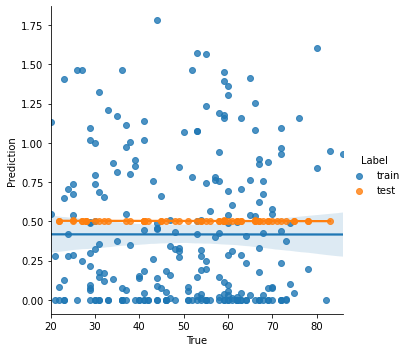

EPOCHS 1
TRAIN :: [LOSS] 2113.734 | VALID :: [LOSS] 2309.151


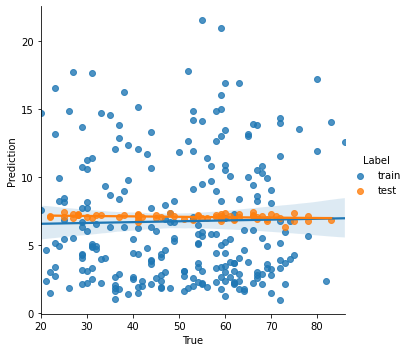

EPOCHS 2
TRAIN :: [LOSS] 488.194 | VALID :: [LOSS] 981.860


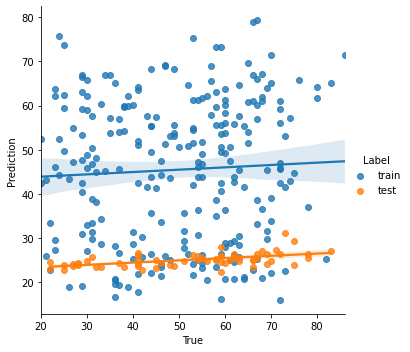

EPOCHS 3
TRAIN :: [LOSS] 237.563 | VALID :: [LOSS] 482.770


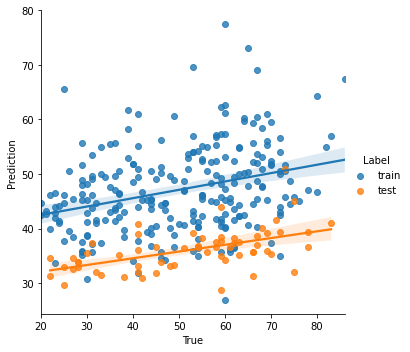

EPOCHS 4
TRAIN :: [LOSS] 223.749 | VALID :: [LOSS] 285.154


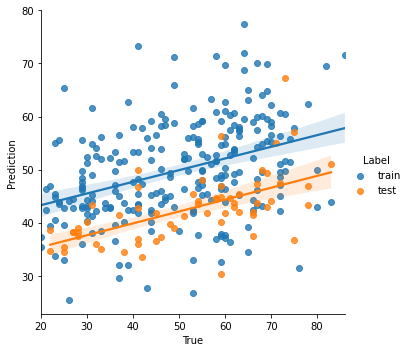

EPOCHS 5
TRAIN :: [LOSS] 196.135 | VALID :: [LOSS] 239.414


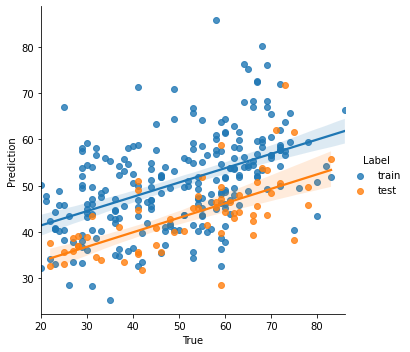

EPOCHS 6
TRAIN :: [LOSS] 173.163 | VALID :: [LOSS] 160.543


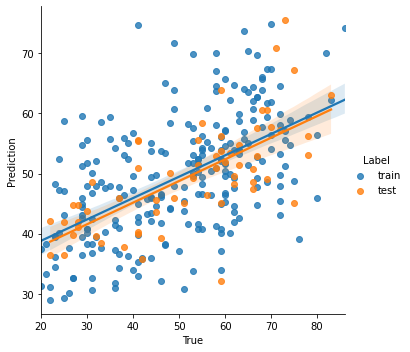

EPOCHS 7
TRAIN :: [LOSS] 165.780 | VALID :: [LOSS] 147.075


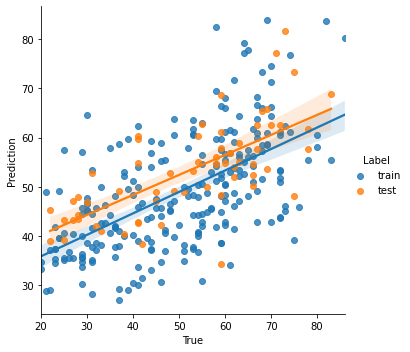

EPOCHS 8
TRAIN :: [LOSS] 165.142 | VALID :: [LOSS] 144.463


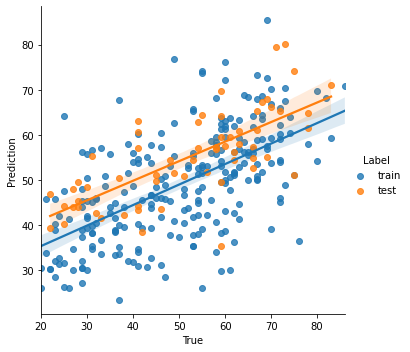

EPOCHS 9
TRAIN :: [LOSS] 156.659 | VALID :: [LOSS] 138.952


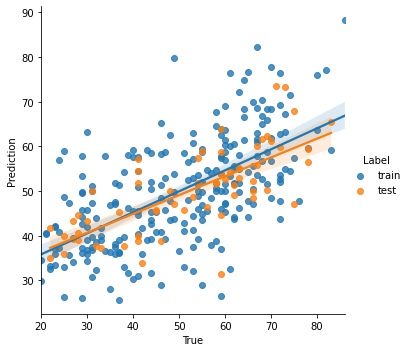

EPOCHS 10
TRAIN :: [LOSS] 173.713 | VALID :: [LOSS] 133.307


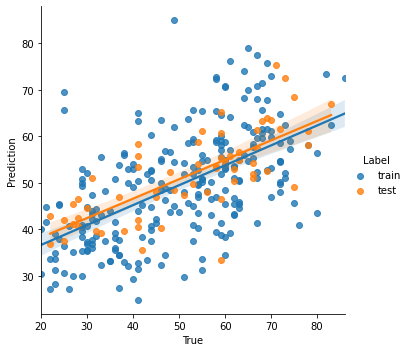

EPOCHS 11
TRAIN :: [LOSS] 150.220 | VALID :: [LOSS] 127.067


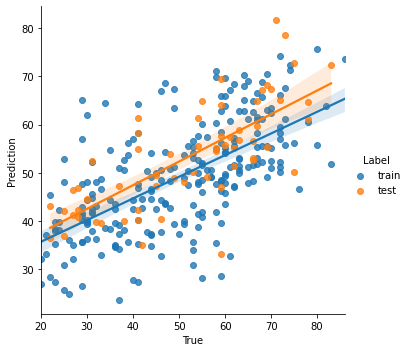

EPOCHS 12
TRAIN :: [LOSS] 142.451 | VALID :: [LOSS] 126.377


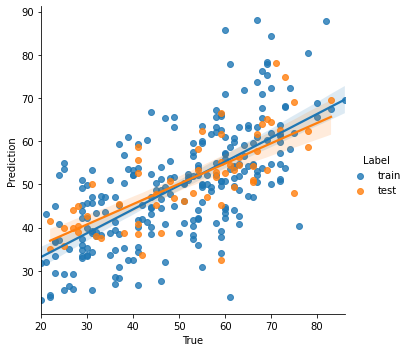

EPOCHS 13
TRAIN :: [LOSS] 143.301 | VALID :: [LOSS] 123.760


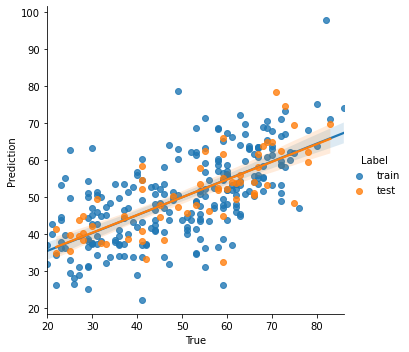

EPOCHS 14
TRAIN :: [LOSS] 159.441 | VALID :: [LOSS] 122.624


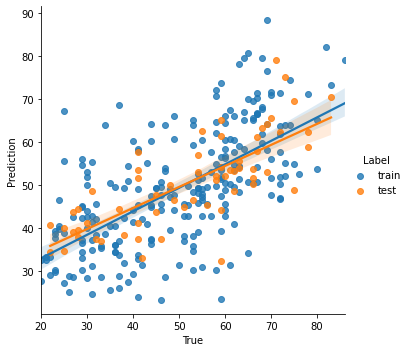

EPOCHS 15
TRAIN :: [LOSS] 151.981 | VALID :: [LOSS] 125.405


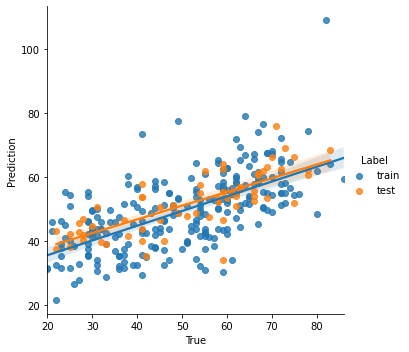

EPOCHS 16
TRAIN :: [LOSS] 123.248 | VALID :: [LOSS] 117.156


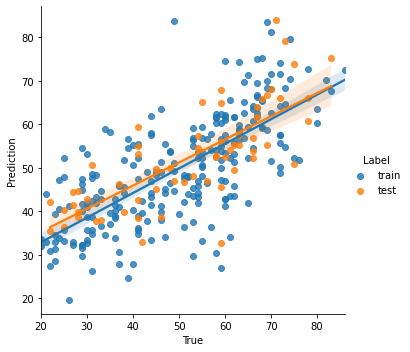

EPOCHS 17
TRAIN :: [LOSS] 143.834 | VALID :: [LOSS] 128.838


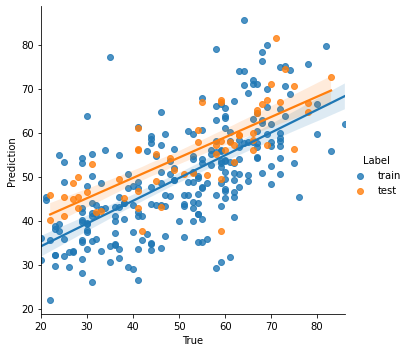

EPOCHS 18
TRAIN :: [LOSS] 144.924 | VALID :: [LOSS] 131.879


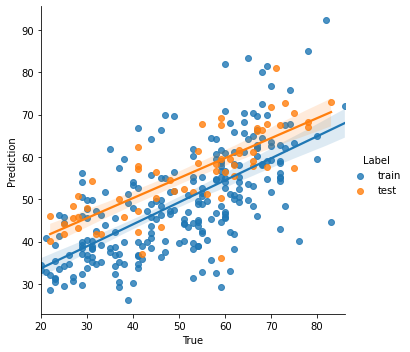

EPOCHS 19
TRAIN :: [LOSS] 138.942 | VALID :: [LOSS] 117.185


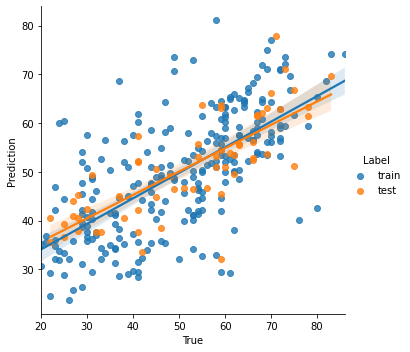

EPOCHS 20
TRAIN :: [LOSS] 135.373 | VALID :: [LOSS] 124.837


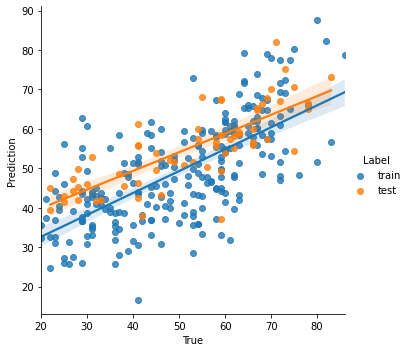

EPOCHS 21
TRAIN :: [LOSS] 118.839 | VALID :: [LOSS] 123.886


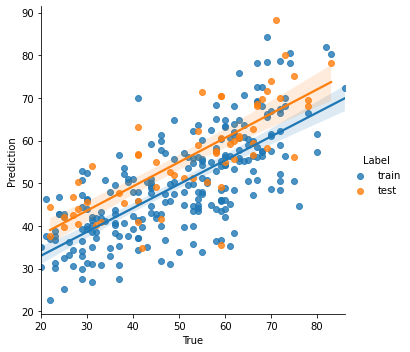

EPOCHS 22
TRAIN :: [LOSS] 118.532 | VALID :: [LOSS] 127.456


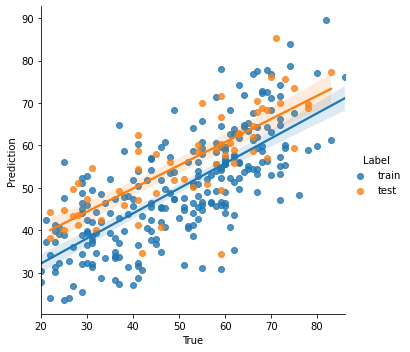

EPOCHS 23
TRAIN :: [LOSS] 123.920 | VALID :: [LOSS] 123.701


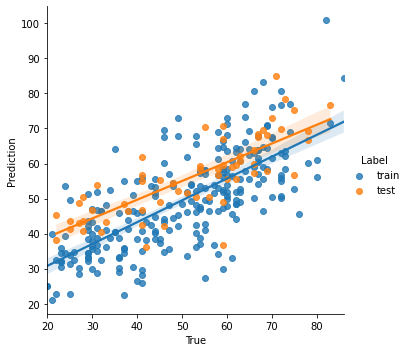

EPOCHS 24
TRAIN :: [LOSS] 124.444 | VALID :: [LOSS] 119.998


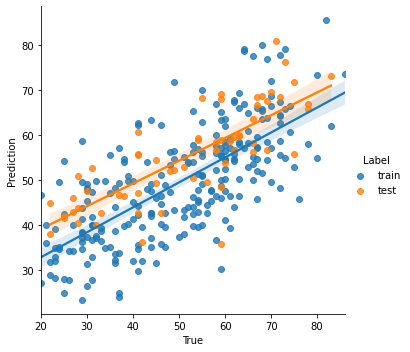

EPOCHS 25
TRAIN :: [LOSS] 117.566 | VALID :: [LOSS] 109.261


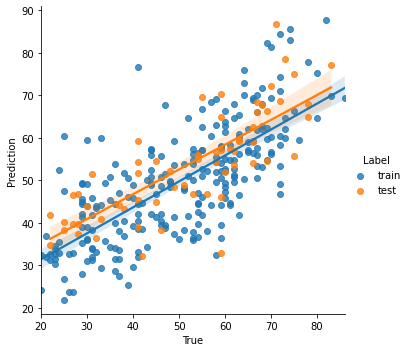

EPOCHS 26
TRAIN :: [LOSS] 122.014 | VALID :: [LOSS] 126.299


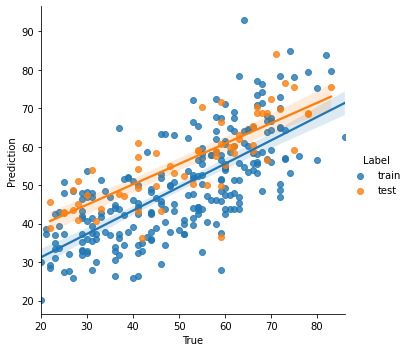

EPOCHS 27
TRAIN :: [LOSS] 126.448 | VALID :: [LOSS] 167.128


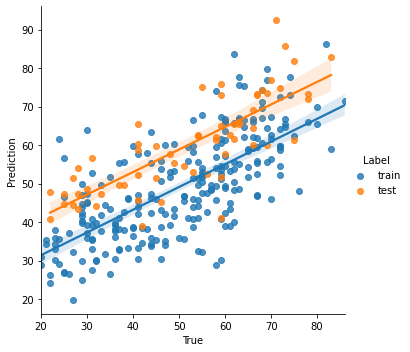

EPOCHS 28
TRAIN :: [LOSS] 114.283 | VALID :: [LOSS] 148.118


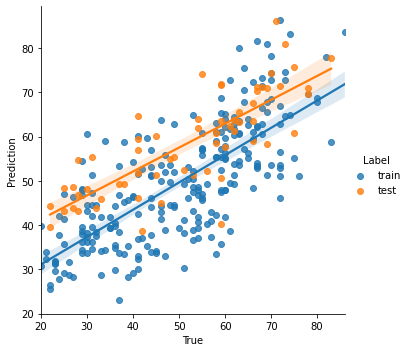

EPOCHS 29
TRAIN :: [LOSS] 119.150 | VALID :: [LOSS] 145.985


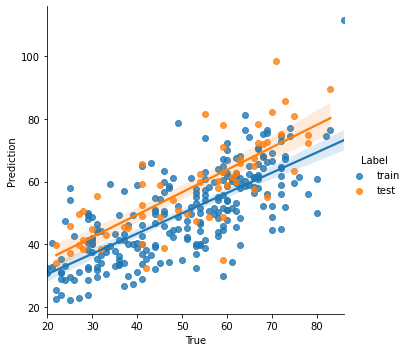

EPOCHS 30
TRAIN :: [LOSS] 128.518 | VALID :: [LOSS] 237.591


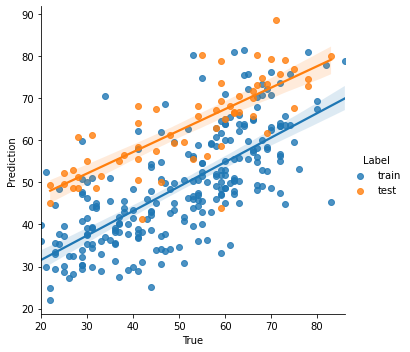

EPOCHS 31
TRAIN :: [LOSS] 119.638 | VALID :: [LOSS] 143.484


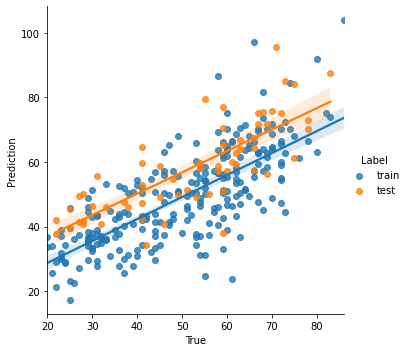

EPOCHS 32
TRAIN :: [LOSS] 93.759 | VALID :: [LOSS] 104.488


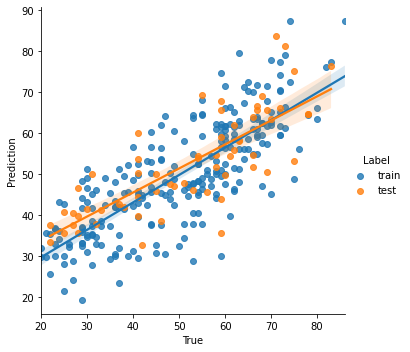

EPOCHS 33
TRAIN :: [LOSS] 100.990 | VALID :: [LOSS] 104.851


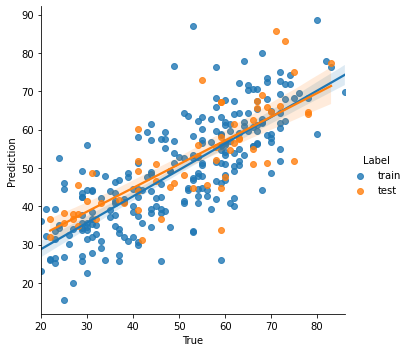

EPOCHS 34
TRAIN :: [LOSS] 95.682 | VALID :: [LOSS] 116.788


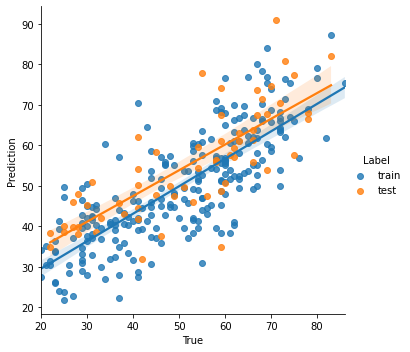

EPOCHS 35
TRAIN :: [LOSS] 91.298 | VALID :: [LOSS] 199.728


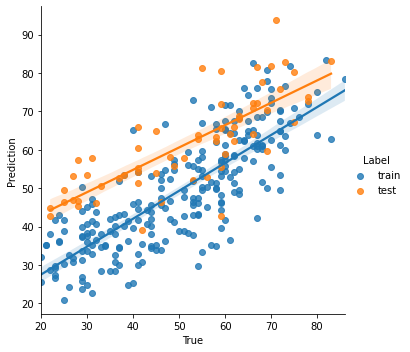

EPOCHS 36
TRAIN :: [LOSS] 97.777 | VALID :: [LOSS] 150.960


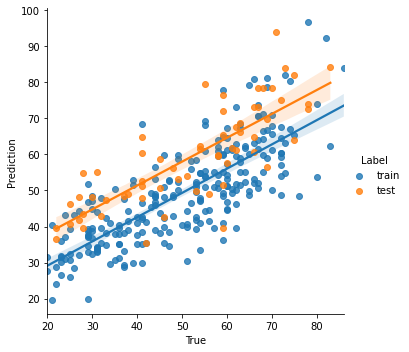

EPOCHS 37
TRAIN :: [LOSS] 88.550 | VALID :: [LOSS] 146.589


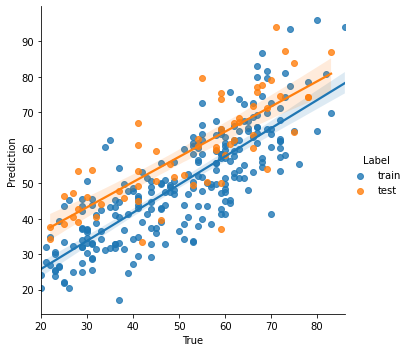

EPOCHS 38
TRAIN :: [LOSS] 90.948 | VALID :: [LOSS] 111.239


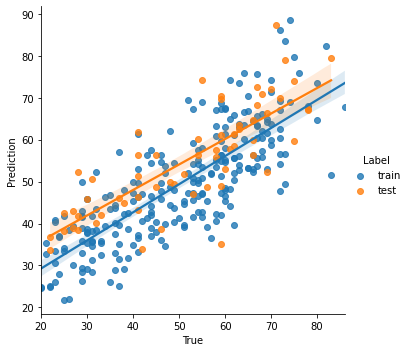

EPOCHS 39
TRAIN :: [LOSS] 80.379 | VALID :: [LOSS] 126.711


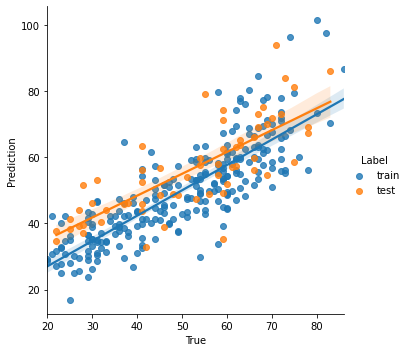

EPOCHS 40
TRAIN :: [LOSS] 94.886 | VALID :: [LOSS] 194.063


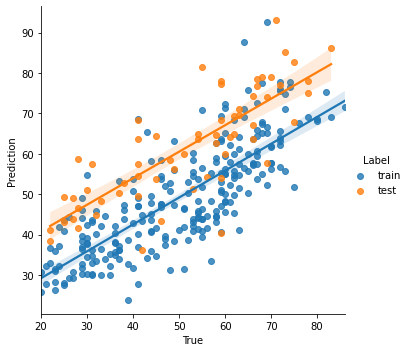

EPOCHS 41
TRAIN :: [LOSS] 82.649 | VALID :: [LOSS] 161.172


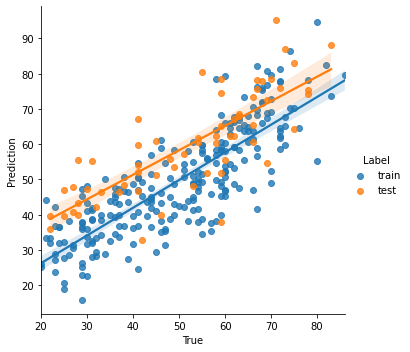

In [ ]:
trn_losses, tst_losses = [], []

for e in range(200):

    # TRAIN
    trn_bth_loss = 0
    trn_trues, trn_preds = [], []
    model.train()
    for i, (x, y) in enumerate(train_loader):

        if resize:
            x, y = F.interpolate(x, size=(64, 64, 64)).to(device), y.to(device)

        else:
            x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x).to(device)

        trn_trues.append(y.to('cpu'))
        trn_preds.append(y_pred.to('cpu'))

        loss = loss_fn(y_pred.squeeze(1), y)
        del x, y, y_pred

        loss.backward()
        optimizer.step()
        if scheduler: scheduler.step()

        trn_bth_loss += loss.item()

    torch.cuda.empty_cache()
    
    ### loss
    trn_losses.append(trn_bth_loss / len(train_loader))

    ### collect trues/predictions
    trn_trues = list(chain(*trn_trues))
    trn_preds = list(chain(*trn_preds))

        
    # TEST
    tst_bth_loss = 0
    model.eval()
    tst_trues, tst_preds = [], []
    with torch.no_grad(): # to not give loads on GPU... :(
        for i, (x, y) in enumerate(test_loader):
            if resize:
                x, y = F.interpolate(x, size=(64, 64, 64)).to(device), y.to(device)

            else:
                x, y = x.to(device), y.to(device)

            y_pred = model.forward(x).to(device)

            tst_trues.append(y.to('cpu'))
            tst_preds.append(y_pred.to('cpu'))

            loss = loss_fn(y_pred.squeeze(1), y)
            del x, y, y_pred

            tst_bth_loss += loss.item()

    torch.cuda.empty_cache()
    ### loss
    tst_losses.append(tst_bth_loss / len(test_loader))

    ### collect trues/predictions
    tst_trues = list(chain(*tst_trues))
    tst_preds = list(chain(*tst_preds))
    
    reg_df = pd.DataFrame({
        'True': list(map(float, trn_trues + tst_trues)),
        'Prediction': list(map(float, trn_preds + tst_preds)),
        'Label': ['train'] * 250 + ['test'] * 62
    })

    print(f'EPOCHS {e}')
    print(f'TRAIN :: [LOSS] {trn_losses[-1]:.3f} | VALID :: [LOSS] {tst_losses[-1]:.3f}')
    sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
    plt.show()

In [30]:
# %load ../2d_slice/src/slice_viewer.py

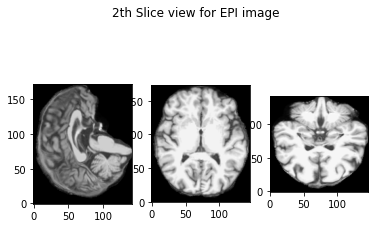

In [41]:
SliceViewer(np.array(train_dset[0][0][0])).triple_view()